# 变分量子本征求解器

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

目前普遍认为，量子计算在近期很有前景的一个应用是处理量子化学问题 [1-2]。**变分量子本征求解器** （VQE）作为这个研究方向的核心应用之一，为研究者们提供了可以在目前含噪的中等规模量子设备（NISQ device）上研究量子化学的可能 [1-4]。其核心任务是求解一个量子尺度上封闭物理系统的哈密顿量 $\hat{H}$ 的基态能量及其对应的量子态。主要的实现方法是通过在量子设备上准备一个参数化的试探波函数 $|\Psi(\boldsymbol\theta)\rangle$ 然后结合经典机器学习中的优化算法（例如梯度下降法）去不断地调整、优化参数 $\boldsymbol\theta$ 使得期望值  $\langle \Psi(\boldsymbol\theta)|\hat{H}|\Psi(\boldsymbol\theta)\rangle$ 最小化。这套方案的基本原理是基于 **Rayleigh-Ritz 变分原理**。 

$$
E_0 = \min_{\boldsymbol\theta} \langle \Psi(\boldsymbol\theta)|\hat{H}|\Psi(\boldsymbol\theta)\rangle.
\tag{1}
$$

其中 $E_0$ 表示该系统的基态能量。从数值分析的角度来看，该问题可以被理解为求解一个**离散化**哈密顿量 $H$（厄米矩阵）的最小本征值 $\lambda_{\min}$ 和其对应的本征向量 $|\Psi_0\rangle$。具体的离散化过程是如何通过建立模型实现的，这属于量子化学的专业领域范畴。精确地解释该过程需要很长的篇幅，这超过了本教程所能处理的范围。我们会在下一节背景知识模块粗略的介绍一下相关知识，感兴趣的读者可以参考 `量子化学: 基本原理和从头计算法`系列丛书 [5]。通常来说，为了能在量子设备上处理量子化学问题，哈密顿量 $H$ 会被表示成为泡利算符 $\{X,Y,Z\}$ 的加权求和形式。

$$
H = \sum_k c_k ~ \bigg( \bigotimes_{j=0}^{M-1} \sigma_j^{(k)} \bigg),
\tag{2}
$$

其中 $c_k$ 表示权重系数, $\sigma_j^{(k)} \in \{I,X,Y,Z\}$ 并且 $M$ 表示所需的量子比特个数。这样一种哈密顿量的表示形式被称为 **泡利字符串**。以下为一个2量子比特的具体例子，

$$
H= 0.12~Y_0 \otimes I_1-0.04~X_0\otimes Z_1.
\tag{3}
$$

在下一节，我们会补充一些关于电子结构问题的背景知识。本质上讨论的就是上述哈密顿量 $H$ 是如何计算的。对于熟悉相关背景的读者，或者主要关心如何在量桨上实现 VQE 的读者，请直接跳转至第三节分析氢分子（$H_2$）基态的具体例子。 

## 背景： 电子结构问题

这里，我们集中讨论下量子化学中的一个基本问题 -- **电子结构问题**。更准确的说，我们关心的是给定分子（molecule）的低位能量本征态。这些信息可以帮助我们预测化学反应的速率和分子的稳定结构等等 [6]。假设一个分子由 $N_n$ 个原子核和 $N_e$ 个电子组成，描述该分子系统总能量的哈密顿量算符 $\hat{H}_{mol}$ 在一次量子化表示下可以写为，

$$
\begin{align}
\hat{H}_{\text{mol}} & = -\sum_{i}\frac{\nabla_{R_i}^2}{2M_i} - \sum_{i} \frac{\nabla_{r_i}^2}{2} -\sum_{i,j}\frac{Z_i}{\lvert R_i - r_j\lvert} + \sum_{i,j>i}\frac{Z_iZ_j}{\lvert R_i - R_j\lvert} + \sum_{i, j>i}\frac{1}{\lvert r_i - r_j\lvert}, 
\tag{4}
\end{align}
$$

其中 $R_i、M_i$ 和 $Z_i$ 分别表示第 $i$ 个原子核的位置、质量和原子序数（原子核内质子数），第 $i$ 个电子的位置则表示为 $r_i$。以上公式右边前两项分别代表原子核和电子的总动能。第三项表示带正电的质子和带负电的电子之间的库伦相互吸引作用。最后两项则表示原子核-原子核之间，电子-电子之间的相互排斥作用。这里，分子哈密顿量 $\hat{H}_\text{mol}$ 使用的是原子单位制能量 **哈特里能量**（Hartree），记为 Ha。$1$ 哈特里能量的大小为 $[\hbar^2/(m_ee^2a_0^2)] = 27.2$ 电子伏或 $630$ 千卡/摩尔，其中 $m_e、e$ 和 $a_0$ 分别表示电子质量、基本电荷和玻尔半径。

**注释1：** 在处理电子结构问题时，我们不考虑自旋-轨道耦合以及超精细结构。如果出于计算需要，可以作为微扰加入。

### 玻恩-奥本海默近似

由于原子核的质量要远大于电子，因而在同样的相互作用下电子的运动速度会比原子核快很多。所以，将原子核所处的位置看成固定 $R_i =$常数 是一种合理的近似。这种通过在时间尺度上将电子行为和原子核行为去耦合的近似处理思想被称为玻恩-奥本海默近似。作为近似的直接结果，公式（4）中原子核的动能项会被消去并且表示原子核-原子核相互排斥作用的项可以被认为是一个能量移位（这个项是与电子位置 $r_i$ 无关的）从而也可以作为常数项被忽略。经过这些步骤后，我们可以把哈密顿量近似为：

$$
\begin{align}
\hat{H}_{\text{electron}} & =  - \sum_{i} \frac{\nabla_{r_i}^2}{2} -\sum_{i,j}\frac{Z_i}{\lvert R_i - r_j\lvert} + \sum_{i, j>i}\frac{1}{\lvert r_i - r_j\lvert} 
\tag{5},
\end{align}
$$

在经过以上近似后，分子中多电子结构的能级在理论上可以通过求解以下不含时薛定谔方程获得：

$$
\hat{H}_{\text{electron}} |\Psi_n \rangle = E_n |\Psi_n \rangle,
\tag{6}
$$

其中 $n$ 指代能级。值得注意的是，电子哈密顿量中电子-电子相互排斥作用的求和项数会随着电子数 $N_e$ 的增多至 $N_e(N_e-1)/2$ 项。这意味着对于一个含有16个电子的氧分子（$O_2$）我们需要计算多达120项的相互排斥作用项。 一般来说，这样的问题是无法从理论上精确求解的。正如狄拉克在 [Quantum mechanics of many-electron systems](https://royalsocietypublishing.org/doi/10.1098/rspa.1929.0094) [7] 所指出的那样，

> *The underlying physical laws necessary for the mathematical theory of a large part of physics and the whole of chemistry are thus completely known, and the difficulty is only that the exact application of these laws leads to equations much too complicated to be soluble.* 
> 
> -- Paul Dirac (1929)

由于解析的方法太复杂，那么我们可以采用数值方法来处理。一个最简单的数值方法（离散化方法）就是把上述作用中无限维度希尔伯特空间离散化为等间距排开的立方体晶格点。在这样一个离散化的空间里，主要运算规则为复数域的线性代数。假设空间的每个轴都离散为等间距排开的 $k$ 个点，则 $N$-电子（为了方便去掉下标 $e$）的多体波函数可以写为 [2]：

$$
|\Psi \rangle = \sum_{\mathbf{x_1}, \ldots, \mathbf{x_N}} \psi(\mathbf{x_1}, \ldots, \mathbf{x_N}) \mathcal{A}(|\mathbf{x_1}, \ldots, \mathbf{x_N}\rangle).
\tag{7}
$$

其中坐标 $|\mathbf{x_j}\rangle = |r_j\rangle |\sigma_j\rangle$ 记录第 $j$ 个电子的空间位置信息和自旋，$|r_j\rangle  = |x_j,y_j,z_j\rangle$ 且 $j\in \{1,2,\cdots,N\}$, $x_j,y_j,z_j \in \{0,1,\cdots,k-1\}$ 同时 $\sigma_j \in \{\downarrow,\uparrow\}$ 表示自旋向下和向上。这样一种离散化方式共计需要 $k^{3N}\times 2^{N}$ 个数据来表示波函数。在这里，$\mathcal{A}$ 表示反对称化操作（根据泡利不相容原理）并且 $\psi(\mathbf{x_1}, \mathbf{x_2}, \ldots, \mathbf{x_N})=\langle\mathbf{x_1}, \mathbf{x_2}, \ldots, \mathbf{x_N}|\Psi\rangle$。 可以看出，经典计算机存储这样一个波函数需要的内存是随着电子个数呈指数增长的。这使得基于这种离散化的经典数值方法，无法模拟超过几十个电子的系统。那么，我们是不是能够通过量子设备来存储和准备这样一个波函数然后求解基态能量 $E_0$ 呢？在下一节中，我们将以最简单的分子系统 -- 氢分子（$H_2$）为例，讲解 VQE 算法。

**注释2：** 关于量子化学和现有数值计算方法的综述也超过了本教程的处理范围，我们推荐感兴趣的读者去查阅以下经典教材 Helgaker 等人撰写的 *'Molecular Electronic-Structure Theory'* [6] 以及 Szabo & Ostlund 撰写的 *'Modern Quantum Chemistry: Introduction to Advanced Electronic Structure Theory'* [8]。 如果需要弥补量子计算和量子化学之间知识空缺，请参考以下综述文章 [Quantum chemistry in the age of quantum computing](https://pubs.acs.org/doi/10.1021/acs.chemrev.8b00803) [1] 和  [Quantum computational chemistry](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.92.015003) [2] 。

**注释3：** 对于量子化学中的能量计算，我们期望能够达到 **化学精度**（chemical accuracy）$1.6\times10^{-3}$ Ha 或者 1 千卡/摩尔。



## 氢分子 $H_2$ 基态能量

### 构造电子哈密顿量

首先，让我们通过下面几行代码引入必要的 library 和 package。量桨的量子化学工具包是基于 `psi4` 和 `openfermion` 进行开发的，所以需要读者先行安装这两个语言包。在进入下面的教程之前，我们强烈建议您先阅读[哈密顿量的构造](./BuildingMolecule_CN.ipynb)教程，该教程介绍了如何使用量桨的量子化学工具包。

**注意：关于环境设置，请参考 [README_CN.md](https://github.com/PaddlePaddle/Quantum/blob/master/README_CN.md).**

In [1]:
import paddle
import paddle_quantum.qchem as qchem
from paddle_quantum.utils import Hamiltonian
from paddle_quantum.circuit import UAnsatz

import os
import matplotlib.pyplot as plt

import numpy
from numpy import pi as PI
from numpy import savez, zeros

# 无视警告
import warnings
warnings.filterwarnings("ignore")

对于具体需要分析的分子，我们需要其**几何构型** (geometry)、**基组**（basis set，例如 STO-3G 基于高斯函数）、**多重度**（multiplicity）以及**分子的净电荷数** (charge) 等多项信息来建模计算出该分子单体积分 (one-body integrations)，双体积分(two-body integrations) 以及哈密顿量等信息。接下来，通过量桨的量子化学工具包将分子的哈密顿量提取出来并储存为 paddle quantum 的 `Hamiltonian` 类，方便我们下一步的操作。

In [2]:
geo = qchem.geometry(structure=[['H', [-0., 0., 0.0]], ['H', [-0., 0., 0.74]]])
# geo = qchem.geometry(file='h2.xyz')

# 将分子信息存储在 molecule 里，包括单体积分（one-body integrations），双体积分（two-body integrations），分子的哈密顿量等
molecule = qchem.get_molecular_data(
    geometry=geo,
    basis='sto-3g',
    charge=0,
    multiplicity=1,
    method="fci",
    if_save=True,
    if_print=True
)
# 提取哈密顿量
molecular_hamiltonian = qchem.spin_hamiltonian(molecule=molecule,
                                               filename=None, 
                                               multiplicity=1, 
                                               mapping_method = 'jordan_wigner',)
# 打印结果
print("\nThe generated h2 Hamiltonian is \n", molecular_hamiltonian)

FCI energy for H2_sto-3g_singlet (2 electrons) is -1.137283834485513.

The generated h2 Hamiltonian is 
 -0.09706626861762556 I
-0.04530261550868938 X0, X1, Y2, Y3
0.04530261550868938 X0, Y1, Y2, X3
0.04530261550868938 Y0, X1, X2, Y3
-0.04530261550868938 Y0, Y1, X2, X3
0.1714128263940239 Z0
0.16868898168693286 Z0, Z1
0.12062523481381837 Z0, Z2
0.16592785032250773 Z0, Z3
0.17141282639402394 Z1
0.16592785032250773 Z1, Z2
0.12062523481381837 Z1, Z3
-0.2234315367466399 Z2
0.17441287610651626 Z2, Z3
-0.2234315367466399 Z3


**注释4：** 生成这个哈密顿量的几何构型中，两个氢原子间的原子间隔（interatomic distance）为 $d = 74$ pm。

除了输入分子的几何结构外，我们还支持读取分子的几何构型文件 (`.xyz` 文件)，关于量子化学工具包更多的用法请参考[哈密顿量的构造](./BuildingMolecule_CN.ipynb)教程。如果你需要测试更多分子的几何构型，请移步至这个[数据库](http://smart.sns.it/molecules/index.html)。

### 搭建量子神经网络（QNN）和试探波函数

在实现VQE的过程中，我们首先需要设计量子神经网络QNN（也可以理解为参数化量子电路）来准备试探波函数 $|\Psi(\boldsymbol\theta)\rangle$。这里，我们提供一个预设好的的深度为 $D$ 层的 4-量子比特的量子电路模板，图中的虚线框内为一层：

![Utheta.jpg](https://release-data.cdn.bcebos.com/PIC%2FUtheta.jpg)

- 我们预设一些该参数化电路的参数，比如宽度为 $N = 4$ 量子位。

- 初始化其中的变量参数，${\bf{\theta }}$ 代表我们量子神经网络中的参数组成的向量。

接下来我们根据上图中的电路设计，通过 Paddle Quantum 的 `UAnsatz` 函数和内置的 `real_entangled_layer(theta, D)` 电路模板来高效搭建量子神经网络。 

In [3]:
def U_theta(theta, Hamiltonian, N, D):
    """
    Quantum Neural Network
    """
    
    # 按照量子比特数量/网络宽度初始化量子神经网络
    cir = UAnsatz(N)
    
    # 内置的 {R_y + CNOT} 电路模板
    cir.real_entangled_layer(theta[:D], D)
    
    # 铺上最后一列 R_y 旋转门
    for i in range(N):
        cir.ry(theta=theta[D][i][0], which_qubit=i)
        
    # 量子神经网络作用在默认的初始态 |0000> 上
    fin_state = cir.run_state_vector()
    
    # 计算给定哈密顿量的期望值
    expectation_val = cir.expecval(Hamiltonian)

    return expectation_val, cir, fin_state

### 配置训练模型 - 损失函数

现在我们已经有了数据和量子神经网络的架构，我们将进一步定义训练参数、模型和损失函数。通过作用量子神经网络 $U(\theta)$ 在初始态 $|0..0\rangle$ 上，我们将得到输出态 $\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle $。进一步，在VQE模型中的损失函数一般由量子态 $\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle$ 关于哈密顿量 $H$ 的期望值 (能量期望值 expectation value) 给出，

$$
\min_{\boldsymbol\theta}  \mathcal{L}(\boldsymbol \theta) = \min_{\boldsymbol\theta} \langle \Psi(\boldsymbol\theta)|H |\Psi(\boldsymbol\theta)\rangle
= \min_{\boldsymbol\theta} \sum_k c_k~\langle \Psi(\boldsymbol\theta)| \bigotimes_j \sigma_j^{(k)}|\Psi(\boldsymbol\theta)\rangle.
\tag{8}
$$

In [4]:
class StateNet(paddle.nn.Layer):
    """
    Construct the model net
    """

    def __init__(self, shape, dtype="float64"):
        super(StateNet, self).__init__()
        
        # 初始化 theta 参数列表，并用 [0, 2*pi] 的均匀分布来填充初始值
        self.theta = self.create_parameter(shape=shape, 
                                           default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*PI),
                                           dtype=dtype, is_bias=False)
        
    # 定义损失函数和前向传播机制
    def forward(self, N, D):
        
        # 计算损失函数/期望值
        loss, cir, fin_state = U_theta(self.theta, molecular_hamiltonian.pauli_str, N, D)

        return loss, cir, fin_state

### 配置训练模型 - 模型参数

在进行量子神经网络的训练之前，我们还需要进行一些训练的超参数设置，主要是学习速率（LR, learning rate）、迭代次数（ITR, iteration）和量子神经网络计算模块的深度（D, Depth）。这里我们设定学习速率为 0.5, 迭代次数为 50 次。读者不妨自行调整来直观感受下超参数调整对训练效果的影响。

In [5]:
ITR = 80  # 设置训练的总迭代次数
LR = 0.4   # 设置学习速率
D = 2      # 设置量子神经网络中重复计算模块的深度 Depth
N = molecular_hamiltonian.n_qubits # 设置参与计算的量子比特数

### 进行训练

当训练模型的各项参数都设置完成后，我们将数据转化为 Paddle 中的张量，进而进行量子神经网络的训练。过程中我们用的是Adam Optimizer，也可以调用Paddle中提供的其他优化器。我们将训练过程中的结果存储在summary_data文件中。

In [6]:
# 确定网络的参数维度
net = StateNet(shape=[D + 1, N, 1])

# 一般来说，我们利用Adam优化器来获得相对好的收敛，
# 当然你可以改成SGD或者是RMS prop.
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

# 记录优化结果
summary_iter, summary_loss = [], []

# 优化循环
for itr in range(1, ITR + 1):

    # 前向传播计算损失函数
    loss, cir, fin_state = net(N, D)

    # 在动态图机制下，反向传播极小化损失函数
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()

    # 更新优化结果
    summary_loss.append(loss.numpy())
    summary_iter.append(itr)

    # 打印结果
    if itr % 20 == 0:
        print("iter:", itr, "loss:", "%.4f" % loss.numpy())
        print("iter:", itr, "Ground state energy:", "%.4f Ha" 
                                            % loss.numpy())
    if itr == ITR:
        print("\n训练后的电路：") 
        print(cir)

# 储存训练结果到 output 文件夹
os.makedirs("output", exist_ok=True)
savez("./output/summary_data", iter = summary_iter, 
                               energy=summary_loss)

iter: 20 loss: -0.8409
iter: 20 Ground state energy: -0.8409 Ha
iter: 40 loss: -1.1311
iter: 40 Ground state energy: -1.1311 Ha
iter: 60 loss: -1.1351
iter: 60 Ground state energy: -1.1351 Ha
iter: 80 loss: -1.1370
iter: 80 Ground state energy: -1.1370 Ha

训练后的电路：
--Ry(1.578)----*--------------x----Ry(4.696)----*--------------x----Ry(9.430)--
               |              |                 |              |               
--Ry(3.986)----x----*---------|----Ry(1.331)----x----*---------|----Ry(4.274)--
                    |         |                      |         |               
--Ry(3.601)---------x----*----|----Ry(1.547)---------x----*----|----Ry(6.260)--
                         |    |                           |    |               
--Ry(1.585)--------------x----*----Ry(4.713)--------------x----*----Ry(2.416)--
                                                                               


### 测试效果
我们现在已经完成了量子神经网络的训练，通过 VQE 得到的基态能量的估计值大致为 $E_0 \approx -1.137$ Ha，这与通过全价构型相互作用（FCI）$E_0 = -1.13728$ Ha 计算得出的值是在化学精度 $\varepsilon = 1.6 \times 10^{-3}$ Ha 内相符合的。

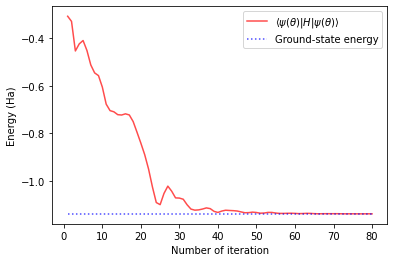

In [7]:
result = numpy.load('./output/summary_data.npz')

eig_val, eig_state = numpy.linalg.eig(
                     Hamiltonian(molecular_hamiltonian.pauli_str).construct_h_matrix())
min_eig_H = numpy.min(eig_val.real)
min_loss = numpy.ones([len(result['iter'])]) * min_eig_H

plt.figure(1)
func1, = plt.plot(result['iter'], result['energy'], 
                  alpha=0.7, marker='', linestyle="-", color='r')
func_min, = plt.plot(result['iter'], min_loss, 
                  alpha=0.7, marker='', linestyle=":", color='b')
plt.xlabel('Number of iteration')
plt.ylabel('Energy (Ha)')

plt.legend(handles=[
    func1,
    func_min
],
    labels=[
        r'$\left\langle {\psi \left( {\theta } \right)} '
        r'\right|H\left| {\psi \left( {\theta } \right)} \right\rangle $',
        'Ground-state energy',
    ], loc='best')

#plt.savefig("vqe.png", bbox_inches='tight', dpi=300)
plt.show()

## 通过 VQE 确定原子间隔

还记得在前面的注释中提到我们默认使用的两个氢原子间原子间隔为 $74$ pm 吗？VQE 的另一个用法便是通过在不同的原子间隔下多次运行然后观察运行结果的最小值是在什么原子间隔发生的，这个间隔即为估计得真实原子间隔。

![vqe-fig-dist](figures/vqe-fig-distance.png)

从上图可以看出，最小值确实发生在 $d = 74$ pm (1 pm = $1\times 10^{-12}$m) 附近，这是与[实验测得数据](https://cccbdb.nist.gov/exp2x.asp?casno=1333740&charge=0)相符合的 $d_{exp} (H_2) = 74.14$ pm.

_______

## 参考文献

[1] Cao, Yudong, et al. Quantum Chemistry in the Age of Quantum Computing. [Chemical reviews 119.19 (2019): 10856-10915.](https://pubs.acs.org/doi/10.1021/acs.chemrev.8b00803)

[2] McArdle, Sam, et al. Quantum computational chemistry. [Reviews of Modern Physics 92.1 (2020): 015003.](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.92.015003)


[3] Peruzzo, A. et al. A variational eigenvalue solver on a photonic quantum processor. [Nat. Commun. 5, 4213 (2014).](https://www.nature.com/articles/ncomms5213)

[4] Moll, Nikolaj, et al. Quantum optimization using variational algorithms on near-term quantum devices. [Quantum Science and Technology 3.3 (2018): 030503.](https://iopscience.iop.org/article/10.1088/2058-9565/aab822)

[5] 徐光宪, 黎乐民, 王德民. 量子化学: 基本原理和从头计算法(上)[M], 第二版. 北京: 科学出版社, 2012; 

[6] Helgaker, Trygve, Poul Jorgensen, and Jeppe Olsen. Molecular electronic-structure theory. John Wiley & Sons, 2014.

[7] Dirac, Paul Adrien Maurice. Quantum mechanics of many-electron systems. [Proceedings of the Royal Society of London. Series A, Containing Papers of a Mathematical and Physical Character 123.792 (1929): 714-733.](https://royalsocietypublishing.org/doi/10.1098/rspa.1929.0094)

[8] Szabo, Attila, and Neil S. Ostlund. Modern quantum chemistry: introduction to advanced electronic structure theory. Courier Corporation, 2012.